# Stochastic Simulation CW1

---
## Question 1
---
### Proposed Density
1.1
To choose an appropriate proposal distribution q(x) for the Banana density, we need a distribution that captures the non-linear dependency of $ x_2 $ on $ x_1 $ and has a reasonable spread to ensure efficient sampling with a high acceptance rate.

The Banana density function is given by:

$\overline{{p}}(x) = \exp \left( -\frac{x_1^2}{10} - \frac{x_2^2}{10} - 2\left(x_2 - x_1^2\right)^2 \right)$

This density has a non-linear structure where $x_2$ is strongly dependent on $x_1$. We can use a product of two Gaussian distributions with:
- $x_1 \sim \mathcal{N}(0, 5)$, which provides the right spread for $x_1$ around zero, mirroring the term $ \exp\left(-\frac{x_1^2}{10}\right)$ in the Banana density.
- $x_2 | x_1 \sim \mathcal{N}(x_1^2, (\frac{1}{2})^2) $, which makes $x_2$ centered around $x_1^2$, mirroring the term $\exp\left(-2(x_2 - x_1^2)^2\right)$ in $\overline{{p}}(x)$.

Thus, we define the proposal distribution as:
$
q(x) = \frac{1}{\sqrt{2\pi \cdot 5}} \exp\left(-\frac{x_1^2}{2 \cdot 5}\right) \cdot \frac{1}{\sqrt{2\pi \cdot \left(\frac{1}{2}\right)^2}} \exp\left(-\frac{(x_2 - x_1^2)^2}{2 \cdot \left(\frac{1}{2}\right)^2}\right).
$

Simplifying, we get:
$
q(x) = \frac{1}{2\pi \cdot \sqrt{5} \cdot \frac{1}{2}} \exp\left(-\frac{x_1^2}{2 \cdot 5} - \frac{(x_2 - x_1^2)^2}{2 \cdot \left(\frac{1}{2}\right)^2}\right).
$


### Calculating M
1.2
$$
M = \sup \frac{\bar p(x)}{q(x)}
$$

$$
= \frac{1}{(2 \pi \sqrt{5} \cdot \frac{1}{2})} e^{\left(-\frac{x_1^2}{10} - \frac{x_2^2}{10} - 2(x_2 - x_1^2)^2 + \frac{x_1^2}{2 \times 5} + \frac{(x_2 - x_1^2)^2}{2 \times (\frac{1}{2})^2}\right)}
$$

$$
= \frac{1}{\pi \sqrt{5}} e^{-\frac{x_2^2}{10}}
$$

$$
\log M = -\frac{x_2^2}{10} - \log(\pi \sqrt{5})
$$

$$
\frac{d}{dx_2} (\log M) = -\frac{x_2}{5} = 0
$$

$$
\Rightarrow x_2 = 0
$$

$M$ is maximized at $x_2 = 0$.

We can grid search $x_1$ for the maximal $M$.


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats, integrate
#np.random.default_rng(1)

Generator(PCG64) at 0x1A32AD217E0

In [65]:
# Define the Banana density function
def banana_density(x1, x2):
    return np.exp(-x1**2 / 10 - x2**2 / 10 - 2 * (x2 - x1**2)**2)

# Define the proposal density q(x)
def proposal_density(x1, x2, s):
    return (2*math.pi*s[0]*s[1])**-1 * np.exp((-x1**2)/(2*s[0]**2) - (x2 - (x1**2))**2/(2*s[1]**2))

# sample
def sample_proposal(s):
    x1 = np.random.normal(0, s[0])
    x2 = np.random.normal(x1**2, s[1])
    return x1, x2
    
# Function to calculate M by finding the maximum of p(x) / q(x)
def calculate_M(s):
    x1_vals = np.linspace(-10, 10, 1000)
    max_ratio = 0

    for xi in x1_vals:
        p_x = banana_density(xi, 0)
        q_x = proposal_density(xi, 0, s=s)
        if q_x > 0:
            ratio = p_x / q_x
            if ratio > max_ratio:
                max_ratio = ratio
    return max_ratio



1.3

In [67]:
# Rejection sampling function
def rejection_sampler(N, s):
    M = calculate_M(s)
    accepted_samples = []
    total_samples = 0

    while len(accepted_samples) < N:
        # Sample from the proposal distribution q(x)
        x1, x2 = sample_proposal(s=s)
        p_x = banana_density(x1, x2)
        q_x = proposal_density(x1, x2, s=s)

        # Acceptance condition in log-domain
        # print(px, qx)
        if p_x <= 0:
            continue
        if math.log(np.random.rand()) < (math.log(p_x) - math.log(q_x) - math.log(M)):
            accepted_samples.append([x1, x2])
        
        total_samples += 1

    acceptance_rate = N / total_samples
    return np.array(accepted_samples), M, acceptance_rate

In [66]:
# Run the rejection sampler and plot the results
N = 50000
samples, m, acceptance_rate = rejection_sampler(N, s=[math.sqrt(5), 0.5])
print(f"M : {m}, Acceptance rate: {acceptance_rate}")

M : 7.025634452704435, Acceptance rate: 0.5122373502986344


C:\Users\tarun\AppData\Local\Temp\ipykernel_32188\1991071773.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.4, label="Accepted Samples", cmap='blue')


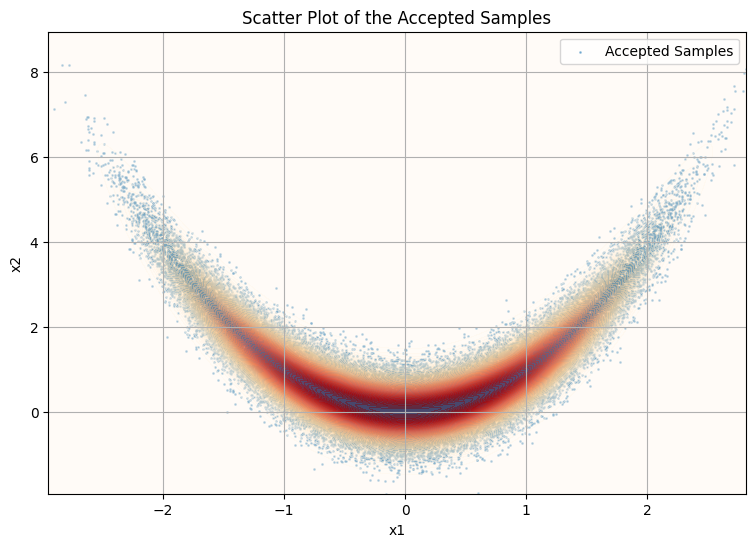

In [59]:
# Plot the scatter plot of accepted samples
plt.figure(figsize=(9, 6))

x1_vals = np.linspace(min(samples[:, 0]), max(samples[:, 0]), 300)
x2_vals = np.linspace(min(samples[:, 1]), max(samples[:, 1]), 300)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
Z = banana_density(X1, X2)

plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.4, label="Accepted Samples", cmap='blue')
plt.contourf(X1, X2, Z, levels=100, cmap='OrRd', alpha=.4)

plt.title("Scatter Plot of the Accepted Samples")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid()
plt.show()

In [50]:
def integrate_function(f, a, b):
    return integrate.dblquad(f, *a, *b)
z, e = integrate_function(banana_density, a=(-12, 12), b=(-12 ,12))
z, e

(3.6013257789914386, 3.267286796670987e-08)

In [51]:
float(z/m)

0.5125979444611085

In [52]:
banana_samples = np.load('samples.npy')
banana_samples

array([[ 1.46623862,  1.7411175 ],
       [-2.55986661,  7.35742137],
       [ 1.74355874,  3.15723297],
       ...,
       [ 0.41782906,  0.72476077],
       [-0.30043485, -0.59013486],
       [ 0.69185684,  0.55065948]])

In [53]:
for i in range(2):
    print(stats.ks_2samp(banana_samples[:,i], samples[:,i]).pvalue)

0.9308137128090315
0.1042204568870494


---
## Question 2
---

In [26]:
from scipy.special import gammaln

### SNIS estimator for the marginal likelihood
$$ \begin{align*} 

p(y_{1:T}) &= \int p(y_{1:T} \mid x) \, \overline{p}(x) \, dx \\

&= \int \frac{p(y_{1:T} \mid x) \, \overline{p}(x)}{q(x)} \, q(x) \, dx \\

\therefore   \hat{p}(y_{1:T}) &= \frac{1}{N} \sum_{i=1}^N \frac{p(y_{1:T} \mid x_i) \, \overline{p}(x_i)}{q(x_i)} \\

\end{align*}$$
Let $ \omega_i = \frac{W_i}{\sum W_i} $ and $ W_i = \frac{\overline{p}(x_i)}{q(x_i)} $ and $ p(y_{1:T} \mid x) = \prod_{t=1}^T p(y_t \mid x) $
$$\begin{align*} 

p^{\text{SNIS}}(y_{1:T}) &= \frac{1}{N} \sum_{i=1}^N p(y_{1:T} \mid x_i) \, \omega_i \\


p^{\text{SNIS}}(y_{1:T}) &= \frac{1}{N} \sum_{i=1}^N \left( \prod_{j=1}^T p(y_j \mid x_i) \right) \omega_i \\

\end{align*}$$


In [54]:
# naive implementation
def logsumexp_naive(nums):
    return np.log(np.sum(np.exp(nums)))

# stable implementation
def logsumexp_stable(values):
    max_val = np.max(values)
    return max_val + np.log(np.sum(np.exp(values - max_val)))

In [55]:
# Test with large values
test_arr = np.array([1000, 1010, 1002])

n = logsumexp_naive(test_arr)
print('naive logsumexp', n)
s = logsumexp_stable(test_arr)
print("stable logsumexp", s)

naive logsumexp inf
stable logsumexp 1010.000380790048


C:\Users\tarun\AppData\Local\Temp\ipykernel_32188\1801521852.py:3: RuntimeWarning: overflow encountered in exp
  return np.log(np.sum(np.exp(nums)))


### Log-SNIS:

#### Gaussian

For $p_1(y_j \mid x) = \mathcal{N}(y_j; x_i, \sigma^2)$, where $\sigma^2 = 0.1$:

$$
p^{\text{SNIS}} = \frac{1}{N} \sum_{i=1}^N \prod_{j=1}^T \frac{1}{\sqrt{2 \pi \cdot 0.1}} \exp\left(-\frac{(y_j - x_i)^2}{2 \cdot 0.1}\right) \cdot \omega_i
$$

$$
= \frac{(\sqrt{5})^T}{N (\sqrt{\pi})^T} \sum_{i=1}^N \prod_{j=1}^T \exp\left(-5 (y_j - x_i)^2\right) \cdot \omega_i
$$

$$
= \frac{1}{N} \cdot \left(\frac{5}{\pi}\right)^{T/2} \sum_{i=1}^N \exp\left(-5 \sum_{j=1}^T (y_j - x_i)^2 + \log \omega_i\right)
$$

Log transformation for numerical stability:

$$
\log p^{\text{SNIS}}_{\text{Gaussian}} = \frac{T}{2} \log \frac{5}{\pi} - \log N + \text{LSE}\left(-5 \sum_{j=1}^T (y_j - x_i)^2 + \log \omega_i\right)
$$

Alternatively:

$$
\log p^{\text{SNIS}}_{\text{Gaussian}} = \frac{T}{2} \log \frac{5}{\pi} - \log N + \text{LSE}\left(-5 \sum_{j=1}^T (y_j - x_i)^2 + \log W_i\right) - \text{LSE}\left(\log W_i\right)
$$



---



For $p_2(y_j \mid x) = \text{St}(y_j; x_i, \nu, \sigma^2)$:

$$
p^{\text{SNIS}} = \frac{1}{N} \sum_{i=1}^N \prod_{j=1}^T \frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\nu \pi \sigma^2}} \left(1 + \frac{(y_j - x_i)^2}{\nu \sigma^2}\right)^{-\frac{\nu + 1}{2}} \cdot \omega_i
$$

$$
= \frac{1}{N} \left(\frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\frac{\nu \pi}{10}}}\right)^T \sum_{i=1}^N \prod_{j=1}^T \left(1 + \frac{10 (y_j - x_i)^2}{\nu}\right)^{-\frac{\nu + 1}{2}} \cdot \omega_i
$$

Log transformation for numerical stability:

$$
\log p^{\text{SNIS}}_{\text{Student-t}} = T \log \Gamma\left(\frac{\nu + 1}{2}\right) - T \log \Gamma\left(\frac{\nu}{2}\right)
- \frac{T}{2} (\log(\pi) + \log(\nu) - log(10)) - \log N
$$

$$
+ \text{LSE}\left(\log \omega_i - \frac{\nu + 1}{2} \log\left(\sum_{j=1}^T \left(1 + \frac{10 (y_j - x_i)^2}{\nu}\right)\right)\right)
$$

Alternatively, accounting for weight normalization:

$$
\log p^{\text{SNIS}}_{\text{Student-t}} = \dots + \text{LSE}\left(\log W_i - \frac{\nu + 1}{2} \log\left(\sum_{j=1}^T \left(1 + \frac{10 (y_j - x_i)^2}{\nu}\right)\right)\right) - \text{LSE}(\log W_i)
$$


In [13]:
# Define the Banana density function
def log_banana_density(x):
    return -x[0]**2 / 10 - x[1]**2 / 10 - 2 * (x[1] - x[0]**2)**2

# Define the proposal density q(x)
def log_proposal_density(x, s):
    return - (x[0]**2)/(2*s[0]**2) - (x[1] - (x[0]**2))**2/(2*s[1]**2) - np.log(2 * np.pi * s[0] * s[1])

In [14]:
# Load data
x_samples = np.load("samples.npy")
y_data = np.load("y.npy")

N, T = len(x_samples), len(y_data)

sigma_sq = 0.1
sigma = np.sqrt(sigma_sq)
proposal_s = [math.sqrt(5), 1/2]
nu=5

def calc_weight(x):
    log_prior = log_banana_density(x)
    log_proposal = log_proposal_density(x, proposal_s)
    log_weight = log_prior - log_proposal
    return log_weight

def snis_estimator_gauss(y_data, x_samples):
    log_likelihoods = []
    weights = []
    N = len(x_samples)
    
    for x in x_samples:
        log_weight = calc_weight(x)
        
        log_likelihoods.append(log_weight - 5 * np.sum((y_data - x[0])**2))
        weights.append(log_weight)
    
    lse = logsumexp_stable(log_likelihoods)
    lse_w = logsumexp_stable(weights)
    
    return lse - lse_w - np.log(len(x_samples))

def snis_estimator_student_t(y_data, x_samples, v=nu):
    log_likelihoods = []
    weights = []
    T = len(y_data)
    N = len(x_samples)
    
    # Parts outside the LSE
    log10 = np.log(10)
    logpi = np.log(np.pi)
    lognu = np.log(v)
    log_gamma_nu_plus = gammaln((v + 1) / 2)
    log_gamma_nu = gammaln(v / 2)
    prefix = log_gamma_nu_plus - log_gamma_nu - (1 / 2) * (logpi + lognu - log10)
    
    for x in x_samples:
        log_weight = calc_weight(x)
        
        log_terms = np.sum(np.log(1 + (10 * (y_data - x[0])**2) / v))
        log_likelihood = log_weight - (v + 1) / 2 * log_terms
        
        log_likelihoods.append(log_likelihood)
        weights.append(log_weight)
    
    lse = logsumexp_stable(log_likelihoods)
    lse_w = logsumexp_stable(weights)
    
    return lse - lse_w + T * prefix - np.log(N)


In [25]:
# Test runs
print("Gaussian:", snis_estimator_gauss(y_data, x_samples))
print("Student t:", snis_estimator_student_t(y_data, x_samples))

Gaussian: -27109.202388556103
Student t: -7585.219014188021


  ---
  